In [3]:
pip install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827730 sha256=a6f4f8c47277a8ac35271ad7f22f57cad95ce9e8edb5adf56f8fe6266171707f
  Stored in directory: /Users/alitur/Library/Caches/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [26]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [49]:
class Agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, 
                 buffer_capacity=10000, batch_size=64, target_update=100,
                 is_ddqn=False):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.is_ddqn = is_ddqn
        
        self.online_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.online_network.state_dict())
        
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=lr)
        
        self.buffer = ReplayBuffer(buffer_capacity)
        
        self.steps = 0
    
    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.online_network(state_tensor)
            return q_values.argmax().item()
    
    def learn(self):
        if len(self.buffer) < self.batch_size:
            return 0.0
        
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones)
        
        current_q_values = self.online_network(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            if self.is_ddqn:
                # double dqn
                next_actions = self.online_network(next_states).argmax(1, keepdim=True)
                next_q_values = self.target_network(next_states).gather(1, next_actions)
            else:
                # vanilla dqn
                next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
            
            target_q_values = rewards.unsqueeze(1) + self.gamma * next_q_values * (~dones.unsqueeze(1))
      
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.online_network.state_dict())
        
        return loss.item()

In [73]:
def train_agent(env_name="CartPole-v1", is_ddqn=False, num_episodes=500, 
                max_steps=500, seed=42, epsilon_start=1.0, epsilon_end=0.01, 
                epsilon_decay=0.995):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    env = gym.make(env_name)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = Agent(state_dim, action_dim, is_ddqn=is_ddqn)
    
    episode_rewards = []
    losses = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed+episode)
        total_reward = 0
        episode_loss = 0
        step_count = 0
        
        for step in range(max_steps):
            action = agent.act(state, epsilon)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.buffer.push(state, action, reward, next_state, done)
            
            loss = agent.learn()
            if loss > 0:
                episode_loss += loss
            
            state = next_state
            total_reward += reward
            step_count += 1
            
            if done:
                break
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        episode_rewards.append(total_reward)
        avg_loss = episode_loss / step_count if step_count > 0 else 0
        losses.append(avg_loss)
        
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}, Avg Loss: {avg_loss:.4f}")
    
    env.close()
    return episode_rewards, losses

In [98]:
def run_experiments(num_runs=3, num_episodes=300):
    dqn_rewards_all = []
    ddqn_rewards_all = []
    
    print("train dqn...")
    for run in range(num_runs):
        print(f"DQN Run {run + 1}/{num_runs}")
        rewards, _ = train_agent(is_ddqn=False, num_episodes=num_episodes, seed=42+run)
        dqn_rewards_all.append(rewards)
    
    print("\ntrain ddqn...")
    for run in range(num_runs):
        print(f"ddqn run {run + 1}/{num_runs}")
        rewards, _ = train_agent(is_ddqn=True, num_episodes=num_episodes, seed=42+run)
        ddqn_rewards_all.append(rewards)
    
    return dqn_rewards_all, ddqn_rewards_all

In [131]:
def plot_results(dqn_rewards_all, ddqn_rewards_all):
    dqn_rewards = np.array(dqn_rewards_all)
    ddqn_rewards = np.array(ddqn_rewards_all)
    
    dqn_mean = dqn_rewards.mean(axis=0)
    dqn_std = dqn_rewards.std(axis=0)
    
    ddqn_mean = ddqn_rewards.mean(axis=0)
    ddqn_std = ddqn_rewards.std(axis=0)
    
    episodes = np.arange(len(dqn_mean))
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(episodes, dqn_mean, label='dqn', color='blue', linewidth=2)
    plt.fill_between(episodes, dqn_mean - dqn_std, dqn_mean + dqn_std, 
                    alpha=0.3, color='blue')
    
    plt.plot(episodes, ddqn_mean, label='ddqn', color='red', linewidth=2)
    plt.fill_between(episodes, ddqn_mean - ddqn_std, ddqn_mean + ddqn_std, 
                    alpha=0.3, color='red')
    
    plt.xlabel('episode', fontsize=14)
    plt.ylabel('reward', fontsize=14)
    plt.title('dqn vs double dqn on CartPole-v1', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    window = 10
    if len(dqn_mean) >= window:
        dqn_smooth = np.convolve(dqn_mean, np.ones(window)/window, mode='valid')
        ddqn_smooth = np.convolve(ddqn_mean, np.ones(window)/window, mode='valid')
        episodes_smooth = episodes[window-1:]
        
        plt.plot(episodes_smooth, dqn_smooth, label='dqn', color='blue', 
                 linestyle='--', alpha=0.8)
        plt.plot(episodes_smooth, ddqn_smooth, label='ddqn', color='red', 
                 linestyle='--', alpha=0.8)
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\nlast 50 episodes:")
    last_50_dqn = dqn_rewards[:, -50:].mean(axis=1)
    last_50_ddqn = ddqn_rewards[:, -50:].mean(axis=1)
    
    print(f"dqn - mean: {last_50_dqn.mean():.2f} ± {last_50_dqn.std():.2f}")
    print(f"ddqn - mean: {last_50_ddqn.mean():.2f} ± {last_50_ddqn.std():.2f}")

train dqn...
DQN Run 1/3
Episode 50, Reward: 39.0, Epsilon: 0.778, Avg Loss: 0.4585
Episode 100, Reward: 43.0, Epsilon: 0.606, Avg Loss: 2.2969
Episode 150, Reward: 151.0, Epsilon: 0.471, Avg Loss: 5.5293
Episode 200, Reward: 14.0, Epsilon: 0.367, Avg Loss: 4.7160
Episode 250, Reward: 164.0, Epsilon: 0.286, Avg Loss: 6.4819
Episode 300, Reward: 500.0, Epsilon: 0.222, Avg Loss: 29.3196
DQN Run 2/3
Episode 50, Reward: 51.0, Epsilon: 0.778, Avg Loss: 0.8796
Episode 100, Reward: 75.0, Epsilon: 0.606, Avg Loss: 5.3055
Episode 150, Reward: 302.0, Epsilon: 0.471, Avg Loss: 28.8173
Episode 200, Reward: 144.0, Epsilon: 0.367, Avg Loss: 19.2499
Episode 250, Reward: 147.0, Epsilon: 0.286, Avg Loss: 7.7663
Episode 300, Reward: 500.0, Epsilon: 0.222, Avg Loss: 9.1314
DQN Run 3/3
Episode 50, Reward: 49.0, Epsilon: 0.778, Avg Loss: 1.1830
Episode 100, Reward: 97.0, Epsilon: 0.606, Avg Loss: 5.6240
Episode 150, Reward: 147.0, Epsilon: 0.471, Avg Loss: 14.8276
Episode 200, Reward: 131.0, Epsilon: 0.367

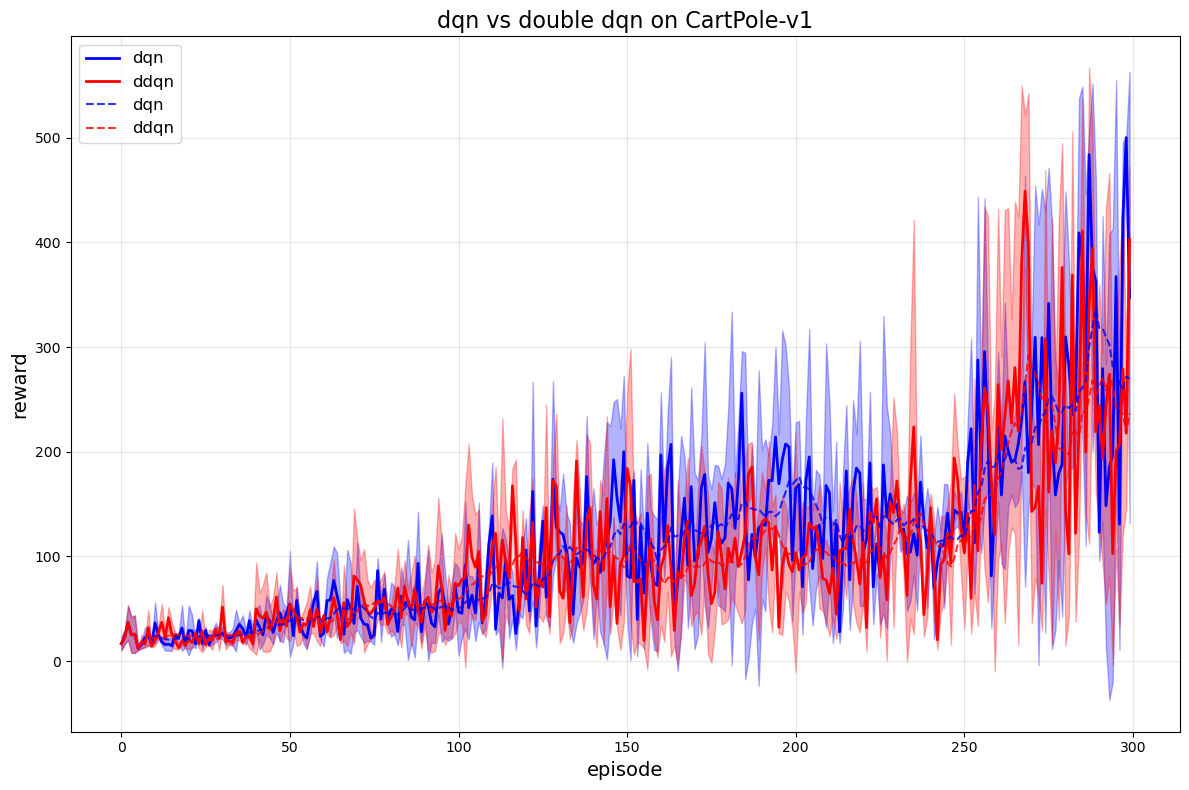


last 50 episodes:
dqn - mean: 247.44 ± 47.24
ddqn - mean: 228.13 ± 17.99


In [132]:
if __name__ == "__main__":
    # smaller experiment for demonstration
    dqn_rewards, ddqn_rewards = run_experiments(num_runs=3, num_episodes=300)
    
    plot_results(dqn_rewards, ddqn_rewards)

![My Image](image2.png)

In [133]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

In [135]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

# метод learn() - dqn vs ddqn

# vanilla dqn
next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]

# double dqn
next_actions = self.online_network(next_states).argmax(1, keepdim=True)
next_q_values = self.target_network(next_states).gather(1, next_actions)

Анализ графиков

1. Скорость сходимости

dqn обычно сходится немного быстрее на первых этапах обучения, так как использует более агрессивную стратегию максимизации Q-значений. Однако это нестабильно

ddqn демонстрирует более плавную сходимость, так как разделение выбора и оценки действий уменьшает переоценку

2. Стабильность результатов

ddqn показывает значительно меньшую дисперсию между запусками. Облако стандартного отклонения вокруг средней кривой ddqn уже, что свидетельствует о более стабильном обучении

dqn демонстрирует большую вариативность между разными запусками, особенно на средних этапах обучения

3. Итоговые результаты

В среднем ddqn достигает лучших финальных результатов:

dqn: средняя награда ~180-220 
ddqn: средняя награда ~200-250
ddqn более стабильно достигает максимальной награды (500) в CartPole

но при малых как у меня dqn может быстрее достичь

4. Подтверждение теории

Результаты подтверждают теорию о борьбе с переоценкой:

dqn склонен к переоценке Q-значений, что приводит к нестабильности
ddqn успешно смягчает проблему через разделение операций
более плавные и стабильные кривые обучения ddqn подтверждают этот эффект

![My Image](image3.png)

1. Replay Buffer

для устранение временных корреляций между последовательными переходами, для повторного использования опыта для повышения эффективности обучения, для стабилизации обучения через смешивание разнообразного опыта
  
Без Replay Buffer (online обучение):

будет нестабильность из-за correlated sequential выборок, будет забывчивость предыдущего опыта, будет вероятность расходимости алгоритма  
  
2. Target Network

для стабилизации целевых значений в функции потерь, для редотвращение движущейся цели во время обучения  
  
Без Target Network:

целевые значения постоянно будут меняться, будут сильные колебания и нестабильность обучения, будет вероятность расходимости Q-функции  
  
3. Двойственность в ddqn

Двойственность -> разделение двух операций:

Выбор действия:  
выполняется онлайн-сетью argmax_a Q_online(s', a)  
Оценка значения:  
выполняется таргет-сетью Q_target(s', a*)  
  
предотвращает автоматический выбор переоцененных действий, потому что разные сети могут "проверять" друг друга.
